In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

RAND_VAL = 42
num_folds = 5  # Number of folds
n_est = 5000  # Increase number of estimators for better performance
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Feature scaling
scale_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

# Feature engineering
def getFeats(df):
    df["Surname_First_Letter"] = df["Surname"].apply(lambda x: x[0])
    df["Age_NumOfProducts"] = df["Age"] ** df["NumOfProducts"]
    df["Risk_Geography"] = df["Geography"].apply(lambda x: 1 if x == "Germany" else 0)
    df["Risk_Age"] = df["Age"].apply(lambda x: 1 if x >= 40 else 0)
    df["Risk_NumOfProducts"] = df["NumOfProducts"].apply(lambda x: 1 if x > 2 else 0)
    df["RiskFactors"] = df["Risk_Geography"] + df["Risk_Age"] + df["Risk_NumOfProducts"]
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] = df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df.drop(['Risk_Geography','Risk_Age','Risk_NumOfProducts'],axis=1,inplace=True)
    return df

df_train = getFeats(df_train)
df_test = getFeats(df_test)

In [3]:
feat_cols = df_train.columns.drop(['id', 'Exited'])
feat_cols = feat_cols.drop(scale_cols)
X = df_train[feat_cols]
y = df_train['Exited']

cat_features = np.where(X.dtypes != np.float64)[0]
folds = StratifiedKFold(n_splits=num_folds, random_state=RAND_VAL, shuffle=True)
test_preds = np.zeros((num_folds, len(df_test)))
auc_vals = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    clf = CatBoostClassifier(
        eval_metric='AUC',
        learning_rate=0.03,
        iterations=n_est,
        depth=8,  # Increase depth for better complexity
        l2_leaf_reg=3  # Regularization parameter
    )
    clf.fit(train_pool, eval_set=val_pool, verbose=300)

    y_pred_val = clf.predict_proba(X_val[feat_cols])[:, 1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ", n_fold, ": ", auc_val)
    auc_vals.append(auc_val)

    y_pred_test = clf.predict_proba(df_test[feat_cols])[:, 1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

0:	test: 0.8813584	best: 0.8813584 (0)	total: 334ms	remaining: 27m 48s
300:	test: 0.8959971	best: 0.8959971 (300)	total: 1m 13s	remaining: 19m 2s
600:	test: 0.8971348	best: 0.8971411 (599)	total: 2m 28s	remaining: 18m 4s
900:	test: 0.8972605	best: 0.8972838 (883)	total: 3m 42s	remaining: 16m 53s
1200:	test: 0.8972762	best: 0.8973234 (1053)	total: 4m 58s	remaining: 15m 42s
1500:	test: 0.8971965	best: 0.8973234 (1053)	total: 6m 13s	remaining: 14m 31s
1800:	test: 0.8971898	best: 0.8973234 (1053)	total: 7m 29s	remaining: 13m 18s
2100:	test: 0.8971022	best: 0.8973234 (1053)	total: 8m 46s	remaining: 12m 6s
2400:	test: 0.8969324	best: 0.8973234 (1053)	total: 10m 3s	remaining: 10m 52s
2700:	test: 0.8967330	best: 0.8973234 (1053)	total: 11m 19s	remaining: 9m 38s
3000:	test: 0.8966063	best: 0.8973234 (1053)	total: 12m 36s	remaining: 8m 24s
3300:	test: 0.8962542	best: 0.8973234 (1053)	total: 13m 53s	remaining: 7m 8s
3600:	test: 0.8960211	best: 0.8973234 (1053)	total: 15m 9s	remaining: 5m 53s
3900

Mean AUC:  0.8978801144419537


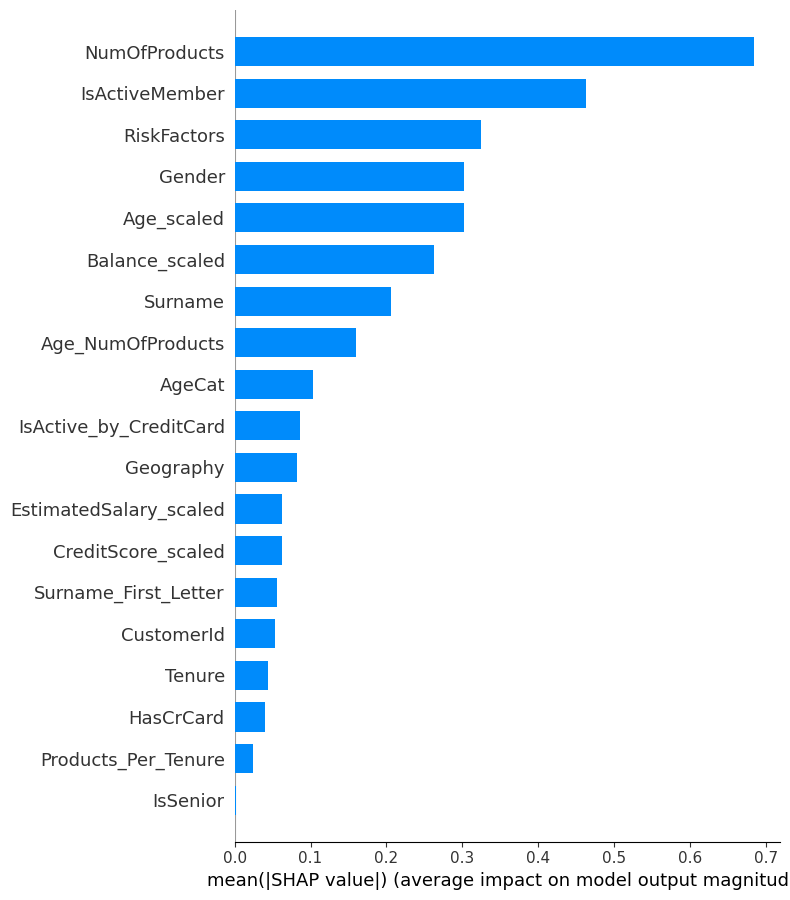

In [4]:
mean_auc = np.mean(auc_vals)
print("Mean AUC: ", mean_auc)

# SHAP analysis
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

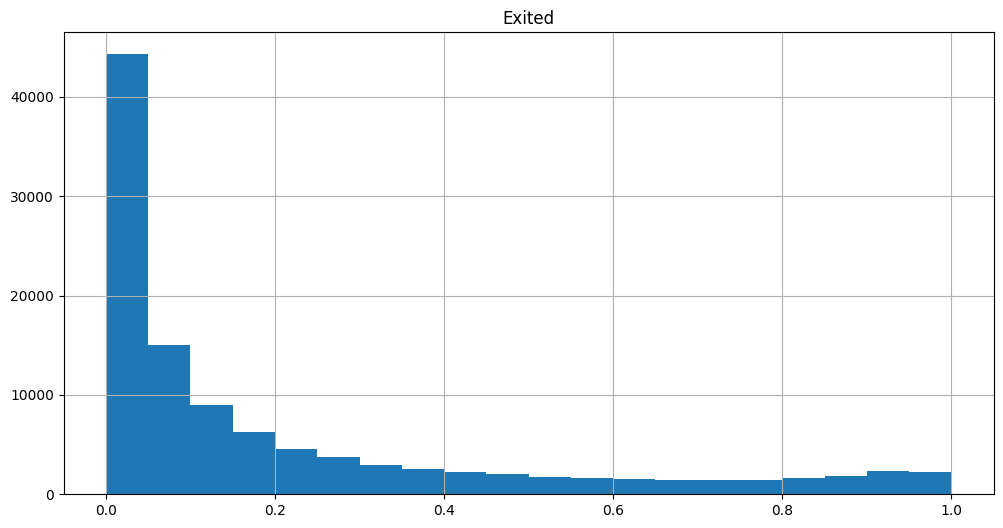

In [5]:
# Create submission file
y_pred = test_preds.mean(axis=0)
df_sub = df_test[['id']]
df_sub['Exited'] = y_pred
df_sub.to_csv("submission.csv", index=False)

# Plot histogram of predicted probabilities
df_sub.hist(column='Exited', bins=20, range=[0, 1], figsize=(12, 6))
plt.show()